<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification?scriptVersionId=131380056" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🚧 Work in progress 🚧 #

**<center><font size=5>RSNA-MICCAI Brain Tumor Classification</font></center>**

<center><img src="https://lingualab.ca/fr/project/language-recovery-psa/featured_hu67ab33455cf328a3b8dbb37d23762824_484672_720x0_resize_lanczos_2.png" alt="equal-2495950-1920" border="0" width="700"></center>

****

**Table of Contents**
- <a href='#overview'>1. Project overview and objectives</a> 
    - <a href='#contributors'>1.1. Contributors</a>
    - <a href='#dataset_overview'>1.2. Data overview</a>
    - <a href='#definitions'>1.3. Imports, Methods, Paths, Reading definitions</a>
- <a href='#exploratory_data'>2. Exploratory Data</a>
    - <a href='#exploratory_data_2_1'>2.1. MRI  scans folders</a>
    - <a href='#exploratory_data_2_2'>2.2. MRI slides scans previews</a>
    - <a href='#exploratory_data_2_3'>2.3. MRI and MGMT values previews</a>
    - <a href='#exploratory_data_2_4'>2.4. Summary</a>
- <a href='#brain_segmentation'>3. Brain segmentation</a>
    - <a href='#brain_segmentation_3_1'>3.1. Importance of Brain Segmentation</a>
    - <a href='#brain_segmentation_3_2'>3.2. Selection Criteria</a>
    - <a href='#brain_segmentation_3_3'>3.3. Contributions of the Library</a>
    - <a href='#brain_segmentation_3_4'>3.4. Summary</a>
- <a href='#utilizing_unet_4'>4. Utilizing the U-Net for Brain MRI Model and RadiomicsShape2D Class</a>
    - <a href='#utilizing_unet_4_1'>4.1. Architecture</a>
    - <a href='#utilizing_unet_4_2'>4.2. Usage Instructions</a>
    - <a href='#utilizing_unet_4_3'>4.3. RadiomicsShape2D Class</a>
    - <a href='#utilizing_unet_4_4'>4.4. Usage Instructions</a>
- <a href='#dataset_creation_5'>5. Dataset creation</a>
- <a href='#exploratory_dataset'>6. Exploratory Dataset</a>
    - <a href='#exploratory_dataset_6_1'>6.1. Summary</a>
- <a href='#analysis'>7. Exploratory Dataset</a>
    - <a href='#analysis_univariee_7_2'>7.2. univariate analysis</a> 

# 🚧 TODO TEAM ADD OTHER SECTION ⚠️

****

# <a id='overview'>1. Project overview and objectives</a>

### Overview:

A malignant brain tumor is a life-threatening condition, specifically glioblastoma, which is the most common and has the poorest prognosis among adult brain cancers, with a median survival of less than a year. The presence of a specific genetic sequence called MGMT promoter methylation in the tumor has been identified as a favorable prognostic factor and a strong predictor of chemotherapy responsiveness.

Currently, the genetic analysis of cancer requires a surgical procedure to obtain a tissue sample, followed by a time-consuming process of determining the genetic characteristics of the tumor, which can take several weeks. Depending on the results and the chosen initial treatment, additional surgeries may be necessary. Developing an accurate method to predict the genetic profile of the cancer solely through imaging (known as radiogenomics) would potentially reduce the number of surgeries and allow for a more tailored therapy approach.

The Radiological Society of North America (RSNA) and the Medical Image Computing and Computer Assisted Intervention Society (MICCAI Society) have collaborated to enhance the diagnosis and treatment planning for glioblastoma patients.

### Competition:

In this competition, participants are tasked with using MRI (magnetic resonance imaging) scans to train and test a model that can predict the genetic subtype of glioblastoma by detecting the presence of MGMT promoter methylation.

Successful outcomes from this competition could significantly contribute to less invasive diagnoses and treatments for brain cancer patients. Introducing new and personalized treatment strategies before surgery holds the potential to improve the management, survival rates, and overall prospects of individuals affected by brain cancer.

### Acknowledgments:

The Radiological Society of North America (RSNA®) is a non-profit organization representing 31 radiologic subspecialties from 145 countries worldwide. RSNA promotes excellence in patient care and healthcare delivery through education, research, and technological innovation.

RSNA provides high-quality educational resources, publishes five top peer-reviewed journals, hosts the world's largest radiology conference, and is dedicated to shaping the future of the profession through the RSNA Research & Education (R&E) Foundation, which has funded $66 million in grants since its establishment. Additionally, RSNA actively supports and facilitates research in medical imaging artificial intelligence (AI) by sponsoring ongoing AI challenge competitions.

The Medical Image Computing and Computer Assisted Intervention Society (MICCAI Society) is committed to advancing research, education, and practice in the field of medical image computing, computer-assisted interventions, biomedical imaging, and medical robotics. The society achieves this objective by organizing high-quality international conferences, workshops, tutorials, and publications that promote the exchange and dissemination of advanced knowledge, expertise, and experiences produced by leading institutions, scientists, physicians, and educators worldwide.

A complete list of acknowledgments can be found on this page.

[RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/data?select=train_labels.csv)

## <a id='contributors'>1.1. Contributors</a>

- [David Goudard](https://www.kaggle.com/goudgoud)
- [Louis-Marie Renaud](https://www.kaggle.com/louismarierenaud)
- [Yannick Stephan](https://github.com/YanSteph)

## <a id='dataset_overview'>1.2. Data overview</a>

The dataset we will be working with consists of MRI data provided by the Radiological Society of North America (RSNA®) and the Medical Imaging Computation and Computer Assistance Society (MICCAI Society). The images are provided in DICOM format and are accompanied by a CSV file containing radiomic features extracted from the images.

The **"train/"** directory contains the training files with the **"train_labels.csv"**

The **"test/"** directory contains the tests files for the competition with the **"sample_submission.csv"**

The files are mpMRI scans, this includes:
- Fluid Attenuated Inversion Recovery (FLAIR)
    * What it is: These are images that detect brain abnormalities, such as edema and inflammatory lesions. These images are sensitive to the detection of anomalies related to inflammatory and infectious diseases of the central nervous system.
    * What it highlights: It helps to detect anomalies in the brain that might not be visible in other MRI sequences.
    * These images allow for the detection of brain abnormalities related to inflammatory and infectious diseases of the central nervous system.
- T1-weighted pre-contrast (T1w)
    * What it is: These are images that highlight soft tissues, such as muscles and nerves, and are useful for visualizing normal brain structures.
    * What it highlights: It allows the visualization of the normal brain structures and also helps in the detection of tumors and lesions.
    * These images allow for the detection of brain tumors and lesions.
- T1-weighted post-contrast (T1Gd)
    * What it is: These are images that use a contrast agent to detect vascular anomalies, such as tumors and lesions, which are more visible after contrast agent administration.
    * What it highlights: It enhances the visibility of vascular anomalies, such as tumors and lesions, making it easier to detect them.
    * These images allow for the detection of vascular anomalies, such as tumors and lesions.
- T2-weighted (T2)
    * What it is: These images detect abnormalities related to demyelination, such as multiple sclerosis, as well as brain tumors and lesions.
    * What it highlights: It helps in the detection of anomalies related to cerebrospinal fluid, such as cysts and brain tumors.
    * These images allow for the detection of anomalies related to demyelination, brain tumors, lesions, and cerebrospinal fluid.

## <a id='definitions'>1.3. Imports, Methods, Paths, Reading definitions</a>

### Imports

In [35]:
# Operating System and File System
import os 

# Data Manipulation and Analysis
import numpy as np  
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt 
# Animation Matplotlib
import matplotlib.animation as anim
import seaborn as sns

# Warnings
import warnings  # For suppressing warnings

# JSON Handling
import json  # For working with JSON data

# Encoding and Decoding Binary Data
import base64  # For encoding and decoding binary data

# Interactive Widgets and Display
import ipywidgets as widgets  # For creating interactive widgets in Jupyter Notebook
from IPython.display import HTML, display  # For displaying HTML content
from IPython.display import Image as show_gif # GIF

# Deep Learning Framework
import torch  # For working with PyTorch deep learning framework

# DICOM File Handling
import pydicom  # For reading DICOM files
from pydicom import dcmread  # For reading DICOM files

# Image Processing and Filtering
import SimpleITK as sitk  # For image filtering
from PIL import Image  # For image processing using the Python Imaging Library (PIL)

# Machine Learning and Data Splitting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm

# Additional Libraries
import glob # Fetch data recusif
!pip install pyradiomics > /dev/null  # Installing the pyradiomics library for radiomics feature extraction
import radiomics  # For extracting radiomics features from medical images

👆 Repository *mateuszbuda_brain-segmentation-pytorch*  will ask permission, tap *y*.

### Configure

In [36]:
# ------------
# Configuration
# ------------

# Show all columns
pd.set_option('display.max_columns', None)
# Suppressing Warnings
warnings.filterwarnings('ignore')

# Define "reader"
# Read serie of image files into a SimpleTK image
sitk_reader = sitk.ImageSeriesReader()
sitk_reader.LoadPrivateTagsOn()

# ------------
# Paths
# ------------

path_rsna_brain_tumor_classification = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"

train_path = path_rsna_brain_tumor_classification + "train/"
train_label_file = path_rsna_brain_tumor_classification + '/train_labels.csv'

# @TODO define path like genere
path = "../input/rsna-miccai-brain-tumor-segmentation-pytorch-unet/"
dataset_path = "/kaggle/input/rsna-miccai-brain-tumor-segmentation-pytorch-unet/rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv"
#path + "rsna_miccai_brain_tumor_brain_segmentation_pytorch_unet.csv/"

# ------------
# Segmentation
# ------------

# Load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI
segmentation_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 
                                    'unet', 
                                    in_channels=3, 
                                    out_channels=1, 
                                    init_features=32, 
                                    pretrained=True, 
                                    trust_repo=False)

# ------------
# Dataset
# ------------

# Dataset of the project, explanation in next section.
dataset = pd.read_csv(train_label_file)
samp_subm = pd.read_csv(path_rsna_brain_tumor_classification + 'sample_submission.csv')

The repository mateuszbuda_brain-segmentation-pytorch does not belong to the list of trusted repositories and as such cannot be downloaded. Do you trust this repository and wish to add it to the trusted list of repositories (y/N)? y


The repository is already trusted.


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


### Methods

In [37]:
# ===============================================
# Images methods
# ===============================================

def get_processed_image(patient_id):
    """
    Retrieves and processes the images for a given patient, grouping them for segmentation.

    Args:
        patient_id (str): The ID of the patient (BraTS21ID).

    Returns:
        numpy.ndarray: A processed image composed of the different images of the patient.
    """
    # SEGMENTATION MODEL LIMITED TO 3 LAYERS
    # T2W SKIPPED
    patient_id = int(patient_id)

    # Paths for image sequences
    t1w_path = f'{train_path}/{str(patient_id).zfill(5)}/T1w'
    flair_path = f'{train_path}/{str(patient_id).zfill(5)}/FLAIR'
    t1wce_path = f'{train_path}/{str(patient_id).zfill(5)}/T1wCE'
    #t2w_path = f'{train_path}/{str(patient_id).zfill(5)}/T2w'

    # Retrieve image sequences
    t1w_image = sequence_filenames(t1w_path)
    flair_image = sequence_filenames(flair_path)
    t1wce_image = sequence_filenames(t1wce_path)
    #t2w_image = sequence_filenames(t2w_path)

    # Resampling
    re_sampled_flair = re_sample_image(flair_image, t1w_image)
    re_sampled_t1wce = re_sample_image(t1wce_image, t1w_image)
    #re_sampled_t2w = re_sample_image(t2w_image, t1w_image)

    # Normalization
    t1w_array = normalize(sitk.GetArrayFromImage(t1w_image))
    flair_array = normalize(sitk.GetArrayFromImage(re_sampled_flair))
    t1wce_array = normalize(sitk.GetArrayFromImage(re_sampled_t1wce))
    #t2w_array = normalize(sitk.GetArrayFromImage(re_sampled_t2w))

    sequence_stacked = np.stack([t1w_array, flair_array, t1wce_array]) #, t2w_array])

    central_slice = t1w_array.shape[0] // 2
    rvb = sequence_stacked[:, central_slice, :, :].transpose(1, 2, 0)
    image = Image.fromarray((rvb * 255).astype(np.uint8))
    return np.array([np.moveaxis(np.array(image.resize((256, 256))), -1, 0)])


def sequence_filenames(path) :
    """
    Retrieves a sequence of images for a given directory.

    Args:
        path (str): The path to the directory containing the DICOM data set.

    Returns:
        SimpleITK.Image: A sequence of images corresponding to the DICOM files in the directory.

    Raises:
        FileNotFoundError: If the specified path does not exist.
    """
    filenames = sitk_reader.GetGDCMSeriesFileNames(path)
    sitk_reader.SetFileNames(filenames)
    image = sitk_reader.Execute()
    
    return image    

def normalize(dataset) :
    """
    Normalizes the data obtained from the images.

    Args:
        dataset (numpy.ndarray): The dataset to be normalized.

    Returns:
        numpy.ndarray: The normalized dataset.
    """
    return (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))


def re_sample_image(image, ref_img):
    """
    Resamples the image to match the dimensions and properties of the reference image.

    Args:
        image (SimpleITK.Image): The image to be resampled.
        ref_img (SimpleITK.Image): The reference image used for resampling.

    Returns:
        SimpleITK.Image: The resampled image.
    """
    re_sampler = sitk.ResampleImageFilter()
    re_sampler.SetReferenceImage(ref_img)
    re_sampler.SetDefaultPixelValue(image.GetPixelIDValue())
    re_sampler.SetInterpolator(sitk.sitkLinear)
    re_sampler.SetOutputSpacing(ref_img.GetSpacing())
    re_sampler.SetOutputDirection(ref_img.GetDirection())
    re_sampler.SetOutputOrigin(ref_img.GetOrigin())
    re_sampler.SetSize(ref_img.GetSize())
    re_sampler.SetTransform(sitk.AffineTransform(image.GetDimension()))
    re_sampled_image = re_sampler.Execute(image)
    
    return re_sampled_image

def segmentation_process(image_resized):
    """
    Obtains the segmented image.

    Args:
        image_resized (numpy.ndarray): The resized image.

    Returns:
        numpy.ndarray: The segmented image.
    """
    segmentation = segmentation_model(torch.Tensor(image_resized))
    return segmentation
    
# ===============================================
# Dataset creation methods
# ===============================================

def init_dataset_radiomics() :
    """
    Initializes the DataFrame structures for radiomics data acquisition.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    df_shapes_columns = ['ID','BraTS21ID','MeshSurface','PixelSurface','Perimeter','PerimeterSurfaceRatio','Sphericity',
                              'SphericalDisproportion','MaximumDiameter','MajorAxisLength','MinorAxisLenth','Elongation']
    df_shapes = pd.DataFrame(columns=df_shapes_columns) 


    df_textures_columns = ['ID','Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 
                           'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 
                           'Idmn', 'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 
                           'MCC', 'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
    df_textures = pd.DataFrame(columns=df_textures_columns) 


    df_first_orders_features_columns=['ID','10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 
                                      'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Range', 'RobustMeanAbsoluteDeviation', 
                                      'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance']
    df_first_orders_features = pd.DataFrame(columns=df_first_orders_features_columns) 
    

def add_patient_data(ID,img_resized,segmentation) :
    """
    Adds data from the specified patient's images to the analysis dataset.

    Args:
        ID (int): The ID of the patient.
        img_resized (numpy.ndarray): Resized image of the patient.
        segmentation (torch.Tensor): Segmentation of the patient's image.

    Returns:
        None
    """
    global df_shapes
    global df_textures
    global df_first_orders_features
    
    # shape
    results = radiomics.shape2D.RadiomicsShape2D(
        sitk.GetImageFromArray(img_resized), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )
    
    shape2D = {}
    shape2D['ID'] = int(ID)
    shape2D['BraTS21ID'] = int(ID)
    shape2D['MeshSurface'] = results.getMeshSurfaceFeatureValue()
    shape2D['PixelSurface'] = results.getPixelSurfaceFeatureValue()
    shape2D['Perimeter'] = results.getPerimeterFeatureValue()
    shape2D['PerimeterSurfaceRatio'] = results.getPerimeterSurfaceRatioFeatureValue()
    shape2D['Sphericity'] = results.getSphericityFeatureValue()
    shape2D['SphericalDisproportion'] = results.getSphericalDisproportionFeatureValue()
    shape2D['MaximumDiameter'] = results.getMaximumDiameterFeatureValue()
    shape2D['MajorAxisLength'] = results.getMajorAxisLengthFeatureValue()
    shape2D['MinorAxisLenth'] = results.getMinorAxisLengthFeatureValue()
    shape2D['Elongation'] = results.getElongationFeatureValue()
    
    df_shapes=df_shapes.append(shape2D,ignore_index=True)
    
    # GLCM
    results=radiomics.glcm.RadiomicsGLCM(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_textures=df_textures.append(res,ignore_index=True)
    
    # First-orders features
    results =  radiomics.firstorder.RadiomicsFirstOrder(
        sitk.GetImageFromArray(img_resized[0,0,:,:].reshape(1, 256, 256)), 
        sitk.GetImageFromArray(np.array([
            segmentation[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8)),
        force2D=True
    )

    results.enableAllFeatures()
    res = results.execute()
    res['ID']=int(ID)

    df_first_orders_features=df_first_orders_features.append(res,ignore_index=True)
    
    
# ===============================================
# Show methods
# ===============================================

def show_segmentation(title, img_src, segmentation):
    """
    Displays the resized source images and the segmentation image in a single line.

    Args:
        title (str): Global title for the plot.
        img_src (numpy.ndarray): Resized source images.
        segmentation (torch.Tensor): Segmentation image.

    Returns:
        None
    """
    titles = ['T1w', 'FLAIR', 'T1wce'] #,'T2w'

    # Create the main figure
    fig = plt.figure()

    # Adjust top margin for the main figure
    fig.subplots_adjust(top=0.85)

    # Set the global title
    fig.suptitle(title, y=0.75)

    # Iterate over the source images
    for i in range(3):
        ax = fig.add_subplot(1, 4, 1+i)
        ax.imshow(img_src[0, i])
        ax.set_title(titles[i])
        ax.set_xticks([])
        ax.set_yticks([])

    # Add the segmentation image
    ax_segmentation = fig.add_subplot(1, 4, 4)
    ax_segmentation.imshow(segmentation.detach().numpy()[0, 0])
    ax_segmentation.set_title('Segmentation')
    ax_segmentation.set_xticks([])
    ax_segmentation.set_yticks([])

    plt.tight_layout()
    plt.show()
    
def show_download_link(df, title = "Download CSV file", filename = "data.csv"):
    """
    Displays a download link for a DataFrame as a CSV file.

    Args:
        df (pandas.DataFrame): The DataFrame to be downloaded.
        title (str): The title of the download link (default: "Download CSV file").
        filename (str): The name of the downloaded file (default: "data.csv").

    Returns:
        None
    """
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload, title=title, filename=filename)
    display(HTML(html))

# ===============================================
# Analysis
# ===============================================

def filter_correlation_matrix(correlation_matrix, correlation_threshold):
    """
    Filters a correlation matrix by keeping only the absolute values greater than or equal to the correlation threshold.

    Args:
        correlation_matrix (pd.DataFrame): The correlation matrix.
        correlation_threshold (float): The correlation threshold for filtering the matrix.

    Returns:
        pd.DataFrame: The filtered correlation matrix.

    """
    filtered_correlation_matrix = correlation_matrix[abs(correlation_matrix) >= correlation_threshold]

    return filtered_correlation_matrix

def find_highly_correlated_groups(correlation_matrix, correlation_threshold = 0.8, filter_duplicated_group = True, convert_indices_to_column_names = True):
    """
    Finds groups of highly correlated variables from a correlation matrix.

    Args:
        correlation_matrix (pd.DataFrame): The correlation matrix.
        correlation_threshold (float): The correlation threshold to consider as highly correlated.
        filter_duplicated_group (bool): Indicates whether to filter out duplicated values in the correlated groups.
        convert_indices_to_column_names (bool): Indicates whether to convert indices to column names.

    Returns:
        List[List[str]]: A list of groups, where each group contains the names of variables that are highly correlated.

    """
    n = correlation_matrix.shape[0]  # Number of variables in the correlation matrix
    groups_correlated = []  # List to store the correlated groups
    
    # Retrieve column names
    column_names = correlation_matrix.columns
    
    # Traverse each variable
    for i in range(n):
        if column_names[i] not in [column_names[v] for g in groups_correlated for v in g]:  # Check if the variable has already been added to a group
            group = [i]  # Create a new group containing the current variable (i)
            for j in range(i+1, n):
                if column_names[j] not in [column_names[v] for g in groups_correlated for v in g]:  # Check if the variable has already been added to a group
                    correlation = correlation_matrix.iloc[i, j]  # Retrieve the correlation between variables i and j
                    if abs(correlation) >= correlation_threshold:  # Strong correlation condition (adjust as needed)
                        group.append(j)  # Add variable j to the group
            
            groups_correlated.append(group)  # Add the group to the list of correlated groups
    
    # Filter out duplicated values in the correlated groups
    if filter_duplicated_group:
        filtered_groups_correlated = []
        for group in groups_correlated:
            filtered_group = list(set(group))  # Convert to a set to eliminate duplicates, then convert back to a list
            filtered_groups_correlated.append(filtered_group)
        groups_correlated = filtered_groups_correlated # Reset by new one
    
    # Convert indices to column names
    if convert_indices_to_column_names:
        groups_correlated = [[column_names[i] for i in group] for group in groups_correlated]
    
    return groups_correlated

def fonc_test_normality(df,graphic=True) : 

    describe = df.describe()
    
    for col in df.columns :

        describe.loc['skewness',col] = stats.skew(df[col])
        describe.loc['kurtosis', col] = stats.kurtosis(df[col],fisher=False)#Vrai kurtosis
        describe.loc['excess_kurtosis',col] = stats.kurtosis(df[col])#Vrai kurtosis
        shapiro_test =  stats.shapiro(df[col])[1]
        describe.loc['shapiro_test',col] = shapiro_test
        describe.loc['normalite',col] = 'Oui' if shapiro_test > 0.05 else 'Non'

        if graphic : 
            figure_size = (6, 2)

            fig = plt.figure(figsize=figure_size)

            plt.subplot(1,3,1)
            sns.histplot(df[col], kde=True)
            plt.title('Histogramme de {}'.format(col),fontsize=8)
            plt.xlabel('Valeur',fontsize=7)
            plt.ylabel('Fréquence',fontsize=7)
            plt.plot(describe.loc['mean',col],0, marker="o", color="red")

            plt.subplot(1,3,2)
            plt.boxplot(x=df[col])
            plt.title('Boxplot de {}'.format(col),fontsize=8)
            #plt.xlabel('Valeur')

            plt.subplot(1,3,3)
            stats.probplot(df[col], plot=plt)
            plt.title('Q-Q plot pour {}'.format(col),fontsize=8)
            plt.xlabel('Quantile théorique',fontsize=7)
            plt.ylabel('Valeurs ordonnées',fontsize=7)
            plt.tight_layout()
            plt.show()

    return describe

<hr>

# <a id='exploratory_data'>2. Exploratory Data</a>

The **"train/"** directory contains the training files for the competition. Each top-level directory represents a subject, and the **"train_labels.csv"** file contains the corresponding targets for each subject, indicating the presence of MGMT promoter methylation.

ℹ️ **Note:** However, report on main contest page, there are unexpected problems with the following three cases in the training dataset: [00109, 00123, 00709].

In [38]:
print('Samples of train folder:', len(dataset))

Samples of train folder: 585


In [39]:
dataset.head(10)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


The "train_labels.csv" file.

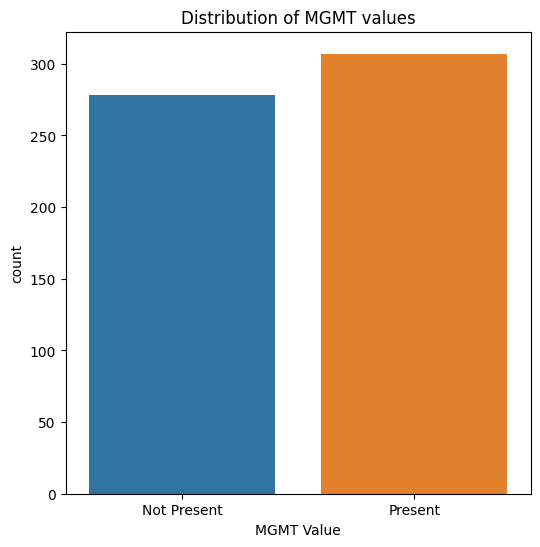

In [40]:
plt.figure(figsize=(6, 6))
sns.countplot(data=dataset, x="MGMT_value")
plt.title("Distribution of MGMT values")
plt.xlabel("MGMT Value")
plt.xticks([0, 1], ["Not Present", "Present"])
plt.show()

The **"test/"** directory contains the test files. For each subject in the test data, there is no file containing the methylation targets, so these values must be predicted. The **"sample_submission.csv"** file is an example of a correctly formatted submission file, with MGMT values of **0.5** for each subject.

Overall, the task of the competition is to predict the presence of MGMT promoter methylation for each subject in the test data.

ℹ️ **Note:** We deduce that we have to separate the sets of given train into part two part train and test for training.

In [41]:
samp_subm.head(1)

,BraTS21ID,MGMT_value
0,1,0.5


## <a id='exploratory_data_2_1'>2.1. MRI  scans folders</a>

In [42]:
# Extract first train sample
first_folder = str(dataset.loc[0, 'BraTS21ID']).zfill(5) + "/"

# Folders content
print(
    "Folders content for all patients:", 
        json.dumps(os.listdir(train_path + first_folder), indent=4)
)

Folders content for all patients: [
    "T2w",
    "T1wCE",
    "T1w",
    "FLAIR"
]


In the first Dataset of the patient, we will explore the images contained in ['T2w', 'T1wCE', 'T1w', 'FLAIR'] of the first patient.

In [43]:
print('Number of FLAIR images:', len(os.listdir(train_path + first_folder +'FLAIR')))
print('Number of T1w images:', len(os.listdir(train_path + first_folder + 'T1w')))
print('Number of T1wCE images:', len(os.listdir(train_path + first_folder + 'T1wCE')))
print('Number of T2w images:', len(os.listdir(train_path + first_folder + 'T2w')))

Number of FLAIR images: 400
Number of T1w images: 33
Number of T1wCE images: 129
Number of T2w images: 408


## <a id='exploratory_data_2_2'>2.2. MRI slides scans previews</a>

In [44]:
image_path = "https://github.com/YanSteph/RSNA-MICCAI-Brain-Tumor-Classification-AI/blob/main/img/scan1.png?raw=true"
html_code = f'<img src="{image_path}" style="width: 700px;" />'
display(HTML(html_code))

## <a id='exploratory_data_2_3'>2.3. MRI and MGMT values previews</a>

ImageSeriesReader (0x5b5d17f639a0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000398747



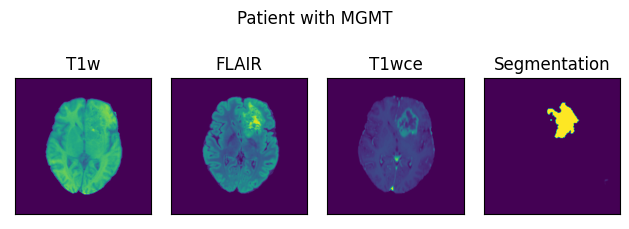

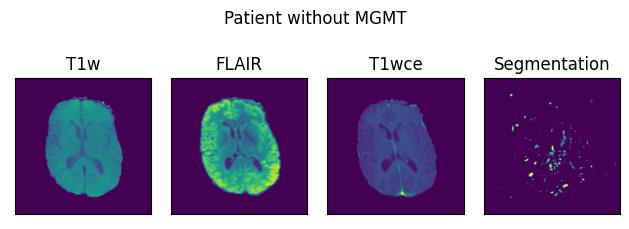

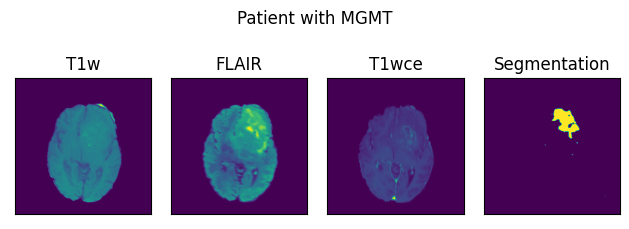

ImageSeriesReader (0x5b5d013dfbf0): Non uniform sampling or missing slices detected,  maximum nonuniformity:9.14411e-05

ImageSeriesReader (0x5b5d013dfbf0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00078569



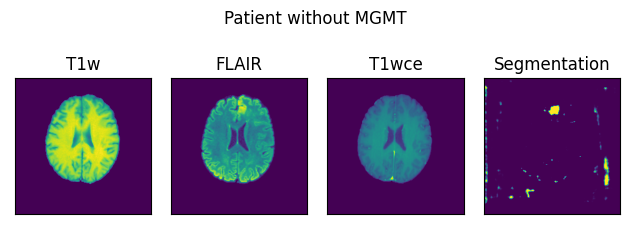

In [ ]:
patient_without_mgmt = dataset.loc[dataset["MGMT_value"] == 0]
patient_with_mgmt = dataset.loc[dataset["MGMT_value"] == 1]

patient_with_mgmt_folder_ids = patient_with_mgmt["BraTS21ID"].iloc[:3]
patient_without_mgmt_folder_ids = patient_without_mgmt["BraTS21ID"].iloc[:3]

for patient_with_mgmt_folder_id, patient_without_mgmt_folder_id in zip(patient_with_mgmt_folder_ids, patient_without_mgmt_folder_ids):
    img_resized = get_processed_image(patient_with_mgmt_folder_id)
    segmentation = segmentation_process(img_resized)
    show_segmentation("Patient with MGMT",img_resized,segmentation)

    img_resized = get_processed_image(patient_without_mgmt_folder_id)
    segmentation = segmentation_process(img_resized)
    show_segmentation("Patient without MGMT",img_resized,segmentation)

## <a id='exploratory_data_2_4'>2.4. Summary</a>

* We deduce that we have to separate the sets of given train into part two part train and test for training.
* Report on main contest page, there are unexpected problems with the following three cases in the training dataset: [00109, 00123, 00709], we exclude this data.
* Exclusion of "/test" folder.

----

# <a id='brain_segmentation'>3. Brain segmentation</a>
The "mateuszbuda_brain-segmentation-pytorch_unet" library was chosen to facilitate brain segmentation from medical images in our project. This section outlines the reasons behind selecting this library and its contribution to achieving accurate brain segmentation results.

Source: [mateuszbuda_brain-segmentation-pytorch_unet on PyTorch Hub](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)

## <a id='brain_segmentation_3_1'>3.1. Importance of Brain Segmentation</a>
Brain segmentation is a crucial task in medical imaging as it enables the extraction of precise information about different regions or classes within the brain structures. Accurate segmentation plays a vital role in various medical applications, including tumor detection, anatomical analysis, and treatment planning.

## <a id='brain_segmentation_3_2'>3.2. Selection Criteria</a>
The "mateuszbuda_brain-segmentation-pytorch_unet" library was chosen based on the following criteria:

* Exceptional Performance: The library has demonstrated exceptional performance in brain segmentation tasks, providing accurate and reliable results.
Unet Architecture: It is specifically designed based on the Unet neural network architecture, which has a proven track record of success in biomedical image segmentation.
* User-Friendly Nature: The library offers a user-friendly interface and efficient implementation, allowing researchers and practitioners to easily integrate it into their projects.

## <a id='brain_segmentation_3_3'>3.3. Contributions of the Library</a>
The utilization of the "mateuszbuda_brain-segmentation-pytorch_unet" library significantly contributed to the acquisition of accurate brain segmentation data for our dataset. By leveraging the library's capabilities, we were able to efficiently segment medical images and extract valuable information for further analysis and research purposes.

## <a id='brain_segmentation_3_4'>3.4. Summary</a>

In summary, the selection of the "mateuszbuda_brain-segmentation-pytorch_unet" library was based on its exceptional performance, user-friendly nature, and utilization of the powerful Unet architecture. This library played a pivotal role in achieving accurate brain segmentation results and provided a solid foundation for our project's objectives.

# <a id='utilizing_unet_4'>4. Utilizing the U-Net for Brain MRI Model and RadiomicsShape2D Class</a>
U-Net for Brain MRI Model
To accomplish tumor segmentation, we will employ the U-Net for Brain MRI model. This section provides an overview of the model's architecture and usage instructions.

## <a id='utilizing_unet_4_1'>4.1. Architecture</a>
The U-Net for Brain MRI model features a U-shaped architecture with branch connections and consists of four levels of blocks. Each block comprises two convolution layers with batch normalization, ReLU activation function, and an encoding part with a max pooling layer. The decoding part utilizes up-convolution. The number of convolution filters varies across the model's levels, ranging from 32 to 256.

## <a id='utilizing_unet_4_2'>4.2. Usage Instructions</a>
To utilize the U-Net for Brain MRI model, follow these steps:

Provide an input brain MRI image with three channels corresponding to pre-contrast, FLAIR, and post-contrast sequences.
Scale the image to a size of 256x256 pixels.
Normalize the image using the z-score method per volume.
The pre-trained U-Net model produces a single-channel probability map indicating anomalous regions in the input image. By applying an appropriate threshold to this probability map, it can be converted into a binary segmentation mask.

## <a id='utilizing_unet_4_3'>4.3. RadiomicsShape2D Class</a>
To perform shape analysis and extract relevant features, we will utilize the "radiomics.shape2D.RadiomicsShape2D" class. This class provides functionalities for analyzing the shape characteristics of segmented regions in medical images.

## <a id='utilizing_unet_4_4'>4.4. Usage Instructions</a>
To utilize the RadiomicsShape2D class, follow these steps:

Provide the segmented regions or masks obtained from the U-Net model.
Instantiate the RadiomicsShape2D class.
Use the available methods and functions to extract shape features, such as volume, surface area, compactness

Source: [Radiomics.shape2D.RadiomicsShape2D ](https://pyradiomics.readthedocs.io/en/latest/features.html#module-radiomics.shape2D)

# <a id='dataset_creation_5'>5. Dataset Preparation</a>

In order to proceed, we need to partition the given training dataset into two sets: training and testing. 

However, it is important to note that there are certain issues with three specific cases in the training dataset, namely [00109, 00123, 00709], as reported on the main contest page. 

Therefore, we will exclude these cases from the dataset.

In [ ]:
# Flag to skip brain segmentation with PyTorch UNet
# If set to True, we will import the dataset that has already been generated
skip_brain_segmentation_pytorch_unet = True

# model_segmentation, load mateuszbuda/brain-segmentation-pytorch, U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI

👆 Flag to skip brain segmentation with PyTorch UNet, default set to *True* else will import the dataset that has already been generated

In [ ]:
if skip_brain_segmentation_pytorch_unet:
    dataset = pd.read_csv(dataset_path)
    
else:
    loader = widgets.IntProgress(min=0, max=len(dataset), description='Loading:')
    display(loader)
    
    # Empty creation of datasets
    init_dataset_radiomics()

    for i in dataset.BraTS21ID :
        loader.value += 1
        img_resized = get_processed_image(i)
        segmentation = segmentation_process(img_resized)
        add_patient_data(i, img_resized, segmentation)

    # Join the 3 datasets
    df_shapes = df_shapes.set_index('ID')
    df_textures = df_textures.set_index('ID')
    df_first_orders_features = df_first_orders_features.set_index('ID')

    df = df_shapes.join(df_textures).join(df_first_orders_features)

    # Define 'BraTS21ID' column as integer IDs
    df['BraTS21ID'] = df['BraTS21ID'].astype(int)
    
    # Merge the old dataset with the new one
    dataset = pd.merge(dataset, df, left_on='BraTS21ID', right_on='BraTS21ID')
    dataset.rename(columns={'BraTS21ID': 'ID'}, inplace=True)
    
# Patient BraTS21ID now is ID, and ID of Dataset
dataset = dataset.set_index('ID')
show_download_link(dataset)

<hr>

# <a id='exploratory_dataset'>6. Exploratory Dataset</a>

These features provide information about various properties of brain MRI images, such as shape, texture, and grayscale statistics. They are commonly used for analysis and classification of medical images to aid in the detection and characterization of brain pathologies.

Here is the requested list of features extracted from brain MRI images:

**Shape Features:**

* **ID:** Sample identifier.
* **MeshSurface:** Mesh surface representing the object's surface using a three-dimensional mesh.
* **PixelSurface:** Surface in pixels representing the object's surface using pixels.
* **Perimeter:** Perimeter of the object, which is the length of the line surrounding the object.
* **PerimeterSurfaceRatio:** Ratio of perimeter to surface, which can provide an indication of the object's shape.
* **Sphericity:** Sphericity, measuring how closely the object resembles a perfect sphere.
* **SphericalDisproportion:** Spherical disproportion, measuring the difference between the object's shape and a perfect sphere.
* **MaximumDiameter:** Maximum diameter, which is the greatest distance between two points of the object.
* **MajorAxisLength:** Major axis length, which is the length of the object's principal axis.
* **MinorAxisLength:** Minor axis length, which is the length of the object's secondary axis.
* **Elongation:** Elongation, measuring the stretching of the object.

**Texture Features:**

* **ID:** Sample identifier.
* **Autocorrelation:** Autocorrelation, measuring the similarity between grayscale levels of an image at different positions.
* **ClusterProminence:** Cluster prominence, measuring the asymmetry and regularity of pixel values within a cluster.
* **ClusterShade:** Cluster shade, measuring the symmetry of pixel values within a cluster.
* **ClusterTendency:** Cluster tendency, measuring the similarity of pixel values within a cluster.
* **Contrast:** Contrast, measuring the brightness differences between neighboring pixels.
* **Correlation:** Correlation, measuring the linear relationship between grayscale levels of an image in different directions.
* **DifferenceAverage:** Difference average, measuring the average differences between grayscale levels of neighboring pixels.
* **DifferenceEntropy:** Difference entropy, measuring the amount of information in the differences between grayscale levels of neighboring pixels.
* **DifferenceVariance:** Difference variance, measuring the variability of differences between grayscale levels of neighboring pixels.
* **Id, Idm, Idmn, Idn, Imc1, Imc2:** These texture-specific features are computed from gray-level co-occurrence matrices and measure different properties of the distribution of gray levels in the image.
* **InverseVariance:** Inverse variance, measuring the reciprocity of gray-level variance in the image.
* **JointAverage:** Joint average, measuring the average gray levels in neighborhood relationships.
* **JointEnergy:** Joint energy, measuring the sum of squared joint gray level values.
* **JointEntropy:** Joint entropy, measuring the amount of information contained in joint gray level values.
* **MCC:** Maximum correlation coefficient, measuring the maximum correlation between grayscale levels of an image in different directions.
* **MaximumProbability:** Maximum probability, measuring the maximum probability of joint grayscale values.
* **SumAverage:** Sum average, measuring the average sum of joint gray level values.
* **SumEntropy:** Sum entropy, measuring the amount of information contained in the sums of joint gray level values.
* **SumSquares:** Sum squares, measuring the sum of squared joint gray level values.

**First-Order Features:**

* **ID:** Sample identifier.
* **MGMT_value:** Presence of MGMT.
* **10Percentile:** 10th percentile, representing the value below which 10% of the pixels are found.
* **90Percentile:** 90th percentile, representing the value below which 90% of the pixels are found.
* **Energy:** Energy, measuring the sum of squared grayscale levels of pixels.
* **Entropy:** Entropy, measuring the amount of information contained in the grayscale levels of the image.
* **InterquartileRange:** Interquartile range, which is the difference between the 75th and 25th percentiles, providing

In [ ]:
dataset.head()

In [ ]:
dataset.info()

In [ ]:
dataset.describe()

In [ ]:
# Select the first row for patients with MGMT_value = 1
patient_with_mgmt = dataset.loc[dataset["MGMT_value"] == 1].mean()

# Select the first row for patients with MGMT_value = 0
patient_without_mgmt = dataset.loc[dataset["MGMT_value"] == 0].mean()

# Transpose the dataframes
patient_with_mgmt = patient_with_mgmt.T
patient_without_mgmt = patient_without_mgmt.T

# Concatenate the transposed dataframes horizontally
patient_explore = pd.concat([patient_with_mgmt, patient_without_mgmt], axis=1)

# Rename the columns
patient_explore.columns = ['Patient MGMT 1 (Mean)', 'Patient MGMT 0 (Mean)']

from colorama import Fore, Style

# Obtenir les 52 dernières lignes du DataFrame patient_explore
patient_tail = patient_explore.tail(52)

    
# Get the last 52 rows of the dataframe
patient_explore.tail(52)

## <a id='exploratory_dataset_6_1'>6.1. Summary</a>

* No null values
* The variable "MGMT_value" has a mean of **0.524786** and a standard deviation of **0.499813**, indicating a bimodal distribution with *slight positive skewness.*
* The `["MeshSurface", "PixelSurface"]` surface variables appear to have a considerable range, with values ranging from **336.5 to 6565.**
* The variable `["Perimeter"]` has a mean of **450.439610** and a standard deviation (std) of **360.639463**, indicating a relatively high dispersion of values. A relatively high spread of values means that object boundaries vary. The individual values can be far from the mean, which induces a great variability in the sizes and shapes of the objects present in the images.
* The `["Sphericity", "SphericalDisproportion", "Elongation"]` shape variables have mean values around **0.4 to 0.6**, indicating a generally non-spherical shape of the depicted objects. (Brain)
* The variable `["Mean"]`  has of **879.400708** and a standard deviation of **1101.421810**, indicating a relatively high variability in the mean values of the images. This suggests that the images show great diversity in their average values, resulting from different characteristics of the objects and the capture conditions.
* The `["Minimum"]` variable has a minimum value of 0, suggesting the possible presence of outliers or black pixels in the images.  
    * (See in previous summary, patients:`[00109, 00123, 00709]`)

----

# <a id='analysis'>7. Analysis</a>

# ⚠️ TODO A faire ⚠️

>

### Correlation Matrix

In [ ]:
correlation_matrix = dataset.corr()

fig, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(correlation_matrix, ax=ax, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

### Correlation Matrix with Strong correlation

As a rule of correlation threshold:
* 0.00-0.19: very weak.
* 0.20-0.39: weak.
* 0.40-0.59: moderate.
* 0.60-0.79: strong.
* 0.80-1.00: very strong.

We will use 0.7, strong.

In [ ]:
correlation_threshold = 0.7
# Filtrer by correlation threshold
filtered_correlation_matrix = filter_correlation_matrix(correlation_matrix, correlation_threshold)

fig, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(filtered_correlation_matrix, ax=ax, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

TODO

### Correlation group with threshold strength

For correlation threshold equal to **0.7, strong.**

In [ ]:
correlation_threshold = 0.7
groups_correlated_threshold_07 = find_highly_correlated_groups(correlation_matrix, correlation_threshold)

for group_correlated in groups_correlated_threshold_07:
    if len(group_correlated) > 1:
        print(group_correlated)

For correlation threshold equal to **0.99, very strong.**

In [ ]:
correlation_threshold = 0.99
groups_correlated_threshold_099 = find_highly_correlated_groups(correlation_matrix, correlation_threshold)

for group_correlated in groups_correlated_threshold_099:
    if len(group_correlated) > 1:
        print(group_correlated)

# <a id='analysis_univariee_7_2'>7.2. Analyse univariée</a>

Test de normalité utilisé : Shapiro-Wilk : Puissant et précis, recommandé pour les échantillons de petite taille

Teste le skewness : mesure l'assymétrie d'une série (0 si suit loi normale). Lorsque la Skewness est égal à 0, le dataset est symétrique. Mais cette mesure nous renseigne aussi sur le type d’asymétrie.

Teste le kurtosis : mesure l'applatissement (vaut 3 si loi normale de Laplace) mais on utilise aussi l'excédent de Kurtosis. Si le Kurtosis est supérieur à 3, alors l’ensemble de données est leptokurtique, c’est-à-dire que les queues sont plus épaisses que la normale. Cela indique un regroupement d’outliers.

Si le Kurtosis est inférieur à 3, alors l’ensemble de données est platykurtique, c’est-à-dire que les queues sont plus fines que la normale. Cela indique un excès négatif d’outlier. En d’autres termes, la plupart des données ont tendance à se rassembler autour de la moyenne.

Lorsque le Kurtosis est égal à 3, alors l’ensemble de données est mésokurtique, c’est-à-dire que les queues sont les mêmes que dans une distribution normale.

ℹ️ Graphiques utilisés :

    histogramme avec courbe de densité de probabilité (le point rouge indique la moyenne)
    boxplot
    QQ plot (diagramme Quantile-Quantile) : permet d'évaluer la pertinence de l'ajustement d'une distribution donnée à un modèle théorique.

<h3>Dataset complet</h3>

In [ ]:
describe=fonc_test_normality(dataset.drop('MGMT_value',axis=1))

print("Description dataset complet")
describe

ℹ️ **Note** : Le jeu de données montre que les les valeurs cibles sont homogènes.

Aucune des variables ne répond au test de Shapiro-Wilk indiquant que les variables explicatives ne suivent pas une loi normale.
Variables ayant un skewness correct : Sphericity, Elongation, Idn, Range,
Variables ayant un bon kurtosis : MajorAxisLength, Elongation, DifferenceAverage, DifferenceEntropy, Idn, JointAverage, SumAverage, Mean,
En analysant les graphiques, variables semblant bonnes sur le Q-Q plot sans trop de valeurs extrêmes : Elongation, DifferenceAverage, DifferenceEntropy, JointEntropy, SumEntropy, Entropy, Maximum, Range
Mais cela ne signifie pas que le dataset soit mauvais, il permet de faire ressortir les variables avec des valeurs extrêmes.
Elongation, Idn et Range semblent être homogènes.

<h3>Mêmes calculs mais que pour les MGMT_value = 1</h3>

In [ ]:
describe_MGMT_1=fonc_test_normality(dataset[dataset.MGMT_value == 1].drop('MGMT_value',axis=1),graphic=False)

print("Description du dataset pour MGMT_value = 1")
describe_MGMT_1

<h3>Mêmes calculs mais que pour les MGMT_value = 0</h3>

In [ ]:
describe_MGMT_0=fonc_test_normality(dataset[dataset.MGMT_value == 0].drop('MGMT_value',axis=1),graphic=False)

print("Description du dataset pour MGMT_value = 0")
describe_MGMT_0

<h3>Comparaison des kurtosis et skewness</h3>

In [ ]:
print("complet")
describe.loc[['skewness','excess_kurtosis'],:]

In [ ]:
print("MGMT = 1")
describe_MGMT_1.loc[['skewness','excess_kurtosis'],:]

ℹ️ Certaines variables ont un meilleur skewness avec un MGMT à 1 que par rapport au dataset global et inversement, ces mêmes variables sont donc sensibles au marqueurs. De même le Kurtosis est sensible aussi. Suivant les variables, la corrélation est positive ou négative entre skewness et kurtosis.

In [ ]:
print("Par variable, variation avec MGMT_value=1 par rapport au dataset global")
for col in describe.columns :
    skew = (describe_MGMT_1.loc['skewness',col]*100/describe.loc['skewness',col])-100
    kurt = (describe_MGMT_1.loc['excess_kurtosis',col]*100/describe.loc['excess_kurtosis',col])-100
    print (f"{col:<32} : skewness {skew:>8.2f}%, excess_kurtosis {kurt:>8.2f}%")
    
T_describe = describe.drop(['Kurtosis'],axis=1).T
T_MGMT_1  = describe_MGMT_1.drop(['Kurtosis','Maximum'],axis=1).T
T_MGMT_0  = describe_MGMT_0.drop(['Kurtosis','Maximum'],axis=1).T


#plt.plot(comparaisonNormalite.kurtosis.index, comparaisonNormalite.kurtosis.value)
#plt.show()
plt.figure(figsize=(12,6))
T_describe[T_describe['kurtosis']<10]['kurtosis'].plot(label='Complet')
T_MGMT_1[T_MGMT_1['kurtosis']<10]['kurtosis'].plot(label='MGMT_1')
T_MGMT_0[T_MGMT_0['kurtosis']<10]['kurtosis'].plot(label='MGMT_0')

plt.title('Comparaison des valeurs de Kurtosis')
plt.legend()
plt.show()

ℹ️ **Note** Une première conclusion pourrait être qu'un gliocome dont la valeur du MGMT = 0 présenterait des variables contenant plus d'outliers.

Il y a des exceptions avec des variation semblant abbérantes comme l'excess de kurtosis pour la variable MajorAxisLength qui explose avec une augmentation de presque 1232%.

Ces variations pourrait indiquer les variables ayant un impact plus important par rapport à la valeur cible. Par Exemple Sphericity à moins d'outliers avec MGMT_value à 1, une meilleur normalité d'Idn.

<h3>Exemple : comparaison de SphericalDisproportion, Entropy, Uniformity
afin de vérifier la normalité en fonction de la valeur cible

In [ ]:
print("SphericalDisproportion pour MGMT_value=1")
fonc_test_normality(dataset[dataset.MGMT_value == 1][['SphericalDisproportion']],graphic=True)      

print("SphericalDisproportion pour MGMT_value=0")
fonc_test_normality(dataset[dataset.MGMT_value == 0][['SphericalDisproportion']],graphic=True)   

print("Entropy pour MGMT_value=1")
fonc_test_normality(dataset[dataset.MGMT_value == 1][['Entropy']],graphic=True)      

print("Entropy pour MGMT_value=0")
fonc_test_normality(dataset[dataset.MGMT_value == 0][['Entropy']],graphic=True)  

print("Uniformity pour MGMT_value=1")
fonc_test_normality(dataset[dataset.MGMT_value == 1][['Uniformity']],graphic=True)      

print("Uniformity pour MGMT_value=0")
fonc_test_normality(dataset[dataset.MGMT_value == 0][['Uniformity']],graphic=True)

<h3>Détection des outliers</h3>
Utilisation du IQR (interquartile range)

In [ ]:
q1=dataset.quantile(0.25)
q3=dataset.quantile(0.75)

IQR=q3-q1

outliers = dataset[((dataset<(q1-1.5*IQR)) | (dataset>(q3+1.5*IQR)))]
outliers

outliers_removed = outliers.dropna().reset_index()
print(outliers_removed)

# ----

In [ ]:
# TODO
# On se base sur l'une des variables quantitatives de chaque groupe retourné par la fonction find_highly_correlated_groups avec un seuil
# de 0.7 afin d'avoir une matrice lisible.

sns.pairplot(data=dataset[['MeshSurface', 'Elongation', 'Sphericity', 'Correlation', 'Energy', 'Autocorrelation', 'ClusterProminence', 'Entropy', 'RootMeanSquared', 'Skewness', 'Kurtosis']], diag_kind='kde')

In [ ]:
#TODO
# Avec les mêmes colonnes que celles utilisées pour le PairPlot, on réalise un Pair grid en séparant par couleur la variable explicative

df_filtered = dataset[['MGMT_value', 'MeshSurface', 'Elongation', 'Sphericity', 'Correlation', 'Energy', 'Autocorrelation', 'ClusterProminence', 'Entropy', 'RootMeanSquared', 'Skewness', 'Kurtosis']]
df_filtered['MGMT_value'] = df_filtered['MGMT_value'].apply(lambda x: "Oui" if x == 1 else "Non")

g = sns.PairGrid(df_filtered, hue='MGMT_value')
g.map(plt.scatter, alpha=.4)
g.add_legend();

# 🚧 test 3

MeshSurface                      : skewness    10.60%, excess_kurtosis    37.33%
PixelSurface                     : skewness    10.46%, excess_kurtosis    36.77%
Perimeter                        : skewness     1.65%, excess_kurtosis     2.27%
PerimeterSurfaceRatio            : skewness     2.71%, excess_kurtosis     2.55%
Sphericity                       : skewness    85.81%, excess_kurtosis   -11.49%
SphericalDisproportion           : skewness     8.05%, excess_kurtosis    65.98%
MaximumDiameter                  : skewness    20.76%, excess_kurtosis   -18.67%
MajorAxisLength                  : skewness    18.44%, excess_kurtosis -1754.60%
MinorAxisLenth                   : skewness     8.21%, excess_kurtosis    52.19%
Elongation                       : skewness     6.41%, excess_kurtosis   -81.26%
Autocorrelation                  : skewness     9.67%, excess_kurtosis    35.20%
ClusterProminence                : skewness    31.60%, excess_kurtosis    48.45%
ClusterShade                     : skewness    23.83%, excess_kurtosis    31.68%
ClusterTendency                  : skewness    36.08%, excess_kurtosis   105.35%
Contrast                         : skewness    -5.30%, excess_kurtosis    -1.71%
Correlation                      : skewness     2.16%, excess_kurtosis    63.42%
DifferenceAverage                : skewness    -9.69%, excess_kurtosis   -37.73%
DifferenceEntropy                : skewness    20.10%, excess_kurtosis   -42.82%
DifferenceVariance               : skewness    -8.46%, excess_kurtosis    -3.92%
Id                               : skewness   -13.34%, excess_kurtosis    -9.83%
Idm                              : skewness   -11.28%, excess_kurtosis   -14.69%
Idmn                             : skewness     0.84%, excess_kurtosis    -7.63%
Idn                              : skewness   -71.54%, excess_kurtosis   -40.69%
Imc1                             : skewness    41.19%, excess_kurtosis    68.27%
Imc2                             : skewness    11.52%, excess_kurtosis    15.82%
InverseVariance                  : skewness   -29.58%, excess_kurtosis    -2.24%
JointAverage                     : skewness    10.37%, excess_kurtosis   -49.45%
JointEnergy                      : skewness     5.35%, excess_kurtosis    49.01%
JointEntropy                     : skewness    24.60%, excess_kurtosis   -53.49%
MCC                              : skewness    -0.55%, excess_kurtosis    55.98%
MaximumProbability               : skewness     3.32%, excess_kurtosis   -16.05%
SumAverage                       : skewness    10.37%, excess_kurtosis   -49.45%
SumEntropy                       : skewness    20.02%, excess_kurtosis   -67.65%
SumSquares                       : skewness    35.75%, excess_kurtosis   105.29%
10Percentile                     : skewness    44.20%, excess_kurtosis   -12.22%
90Percentile                     : skewness    -4.02%, excess_kurtosis     1.11%
Energy                           : skewness     6.95%, excess_kurtosis    11.98%
Entropy                          : skewness    47.87%, excess_kurtosis   -70.16%
InterquartileRange               : skewness    18.80%, excess_kurtosis    87.89%
Kurtosis                         : skewness   -66.52%, excess_kurtosis   -87.55%
Maximum                          : skewness    15.54%, excess_kurtosis     9.56%
MeanAbsoluteDeviation            : skewness     8.57%, excess_kurtosis    83.60%
Mean                             : skewness    16.10%, excess_kurtosis   -24.84%
Median                           : skewness     5.56%, excess_kurtosis    -7.40%
Minimum                          : skewness   -18.25%, excess_kurtosis     4.98%
Range                            : skewness    13.32%, excess_kurtosis   -10.82%
RobustMeanAbsoluteDeviation      : skewness    14.10%, excess_kurtosis    92.15%
RootMeanSquared                  : skewness    16.84%, excess_kurtosis   -32.18%
Skewness                         : skewness   -58.03%, excess_kurtosis   -79.56%
TotalEnergy                      : skewness     6.95%, excess_kurtosis    11.98%
Uniformity                       : skewness     9.75%, excess_kurtosis   110.36%
Variance

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button


# Assuming you have a DataFrame named 'df' with two columns 'x' and 'y'
# You can replace these with the actual column names from your DataFrame

# Create a new figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assign a constant value to the Z-coordinate


colors = ['r' if value == 1 else 'b' for value in dataset['MGMT_value']]


import numpy as np
from sklearn.preprocessing import RobustScaler

# Extract 'Entropy' and 'Elongation' columns from the dataset
entropy_data = dataset['Entropy'].values.reshape(-1, 1)
elongation_data = dataset['Elongation'].values.reshape(-1, 1)

# ⚠️ no senbible au valeur aberante
entropy_scaler = RobustScaler()
elongation_scaler = RobustScaler()

# Fit and transform the data using the scalers
normalized_entropy = entropy_scaler.fit_transform(entropy_data)
normalized_elongation = elongation_scaler.fit_transform(elongation_data)

# Update the dataset with normalized values
new_dataset = dataset
new_dataset['Entropy'] = normalized_entropy
new_dataset['Elongation'] = normalized_elongation
new_dataset['MGMT_value2'] = dataset['MGMT_value']

# Plot the scatter points with constant Z-coordinate
# ⚠️ Separeation add z = new_dataset['MGMT_value2']
z = 0
ax.scatter(new_dataset['Entropy'], new_dataset['Elongation'], z, c=colors)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D Scatter Plot in 3D Space')


# Function to update the plot for each frame
def update(frame):
    ax.view_init(elev=30, azim=frame)  # Set the azimuth angle for rotation

# Create the animation
animation = FuncAnimation(fig, update, frames=range(0, 360, 5), interval=100)

ax.set_zscale('linear')  # Set linear scaling for the 'z' axis
ax.zaxis.set_tick_params(labelsize=12)  # Adjust the font size of the 'z' axis labels

# Function to handle zoom button click event
def zoom(event):
    ax.set_xlim(0, 10)  # Set the x-axis limits for zoom
    ax.set_ylim(0, 20)  # Set the y-axis limits for zoom
    ax.set_zlim(0, 30)  # Set the z-axis limits for zoom
    fig.canvas.draw()  # Redraw the figure

# Create a zoom button and position it outside the plot area
zoom_button_ax = plt.axes([0.85, 0.05, 0.1, 0.075])
zoom_button = Button(zoom_button_ax, 'Zoom')
zoom_button.on_clicked(zoom)

# Adjust the figure layout to make space for the zoom button
plt.subplots_adjust(right=0.8)

# Set the appropriate backend for animation
#plt.rcParams['animation.html'] = 'jshtml'  # Use this for Jupyter Notebook
plt.rcParams['animation.html'] = 'html5'  # Use this for other Python environments

# Display the animation
plt.close()  # Close the initial figure to prevent duplicate display
# Show the plot
animation

In [ ]:
#TODO
def create_kde_mgmt_pos_neg(df, x, y) : 
    """
    Displays 3 KDE plots that show the bivariate density using the columns x and y from a dataframe.

    Args:
        df: DataFrame, the dataframe whose 2 variables are going to be used for the KDE plot.
        x, y: String, the two columns
        
    """
    fig = plt.figure(figsize=(21, 7))

    plt.subplot(1,3,1)
    plt.title("Densité bivariée de "+y+" par rapport à "+x)
    sns.kdeplot(data=df, x=x, y=y, hue="MGMT_value")

    plt.subplot(1,3,2)
    plt.title("Densité bivariée pour MGMT positif")
    sns.kdeplot(data=df[df["MGMT_value"] == 1], x=x, y=y)

    plt.subplot(1,3,3)
    plt.title("Densité bivariée pour MGMT négatif")
    sns.kdeplot(data=df[df["MGMT_value"] == 0], x=x, y=y)
    plt.show();

    
# On veut utiliser la densité bivarié entre des variables liées à la forme de la tumeur et la texture de la tumeur.
# Cela permettrait de voir si une variable a une influence différente sur une autre variable si la valeur de MGMT est de 1 ou de 0

create_kde_mgmt_pos_neg(dataset, "Elongation", "Contrast")

create_kde_mgmt_pos_neg(dataset, "MaximumDiameter", "Contrast")

create_kde_mgmt_pos_neg(dataset, "Sphericity", "ClusterShade")

create_kde_mgmt_pos_neg(dataset, "Elongation", "Idm")

# Ici, nous ne pouvons pas vraiment conclure, il ne semble pas y avoir de différence significative

# Etape 3/ Nettoyage et Pre-processing :

In [ ]:
#TODO

In [ ]:
#TODO

In [ ]:
#TODO